In [4]:
import pandas as pd
import numpy as np

data = pd.read_pickle('../pkl_data/GRAPE.pkl')




def create_lists(df):
    patients = []
    masks = []
    for i, row in df.iterrows():
        visits = []
        mask = []
        for val in row:
            if isinstance(val, float) and pd.isna(val):
                visits.append(np.full_like(df.iloc[0,0], np.nan, dtype=float))
                mask.append(0)
            else:
                visits.append(np.array(val, dtype=float))
                mask.append(1)
        patients.append(np.stack(visits))
        masks.append(np.array(mask, dtype=int))
    return np.array(patients, dtype=float), np.array(masks, dtype=int)




In [5]:
patients, masks = create_lists(data)
patients

array([[[21., 22., 20., ..., 19., 20., 21.],
        [31., 28., 28., ..., 21., 21., 18.],
        [26., 25., 26., ..., 22., 25., 22.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[24., 26., 23., ..., 22., 25., 22.],
        [30., 27., 27., ..., 21., 24., 25.],
        [31., 29., 27., ..., 24., 27., 25.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[31., 30., 29., ..., 17., 18., 25.],
        [26., 28., 28., ..., 25., 16., 27.],
        [30., 29., 28., ..., 22., 22., 23.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[32., 31., 32., ..., 18., 16., 26.],
        [28., 30., 33., ...,  4.,  9., 15.],
        [22., 26., 23., ..., 10., 19., 28.

In [6]:
from sklearn.preprocessing import StandardScaler

flat = patients.reshape(-1, patients.shape[-1])
mask_flat = masks.reshape(-1, 1)


valid_rows = flat[mask_flat[:,0]==1]
scaler = StandardScaler()
scaler.fit(valid_rows)

flat_scaled = scaler.transform(flat)  #NaN are ignored
scaled_patients = flat_scaled.reshape(patients.shape)  #back to normal shape

scaled_patients

array([[[-0.75576311, -0.62462336, -0.7219819 , ...,  0.26373417,
          0.30697575, -0.15611822],
        [ 0.69288029,  0.2841914 ,  0.42210738, ...,  0.50050034,
          0.43272078, -0.65346626],
        [-0.03144141, -0.17021598,  0.13608506, ...,  0.61888343,
          0.93570089,  0.00966446],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.32117009, -0.01874685, -0.29294842, ...,  0.61888343,
          0.93570089,  0.00966446],
        [ 0.54801595,  0.13272228,  0.27909622, ...,  0.50050034,
          0.80995586,  0.5070125 ],
        [ 0.69288029,  0.43566053,  0.27909622, ...,  0.85564961,
          1.18719095,  0.5070125 ],
        ...,
        [        nan,         nan,         nan, ...,  

In [7]:
from sklearn.decomposition import PCA
N, T, P = patients.shape
n = 7
pca = PCA(n_components=n)
pca.fit(valid_rows)
flat_visits_emb = pca.transform(np.nan_to_num(flat_scaled, nan=0.0))

visit_embeddings = flat_visits_emb.reshape(N, T, n)

diffs = np.diff(visit_embeddings, axis=1)
mean_slope = np.sum(diffs * masks[:,1:,None], axis=1) / np.sum(masks[:,1:], axis=1)[:,None]

mean_embedding = np.sum(visit_embeddings * masks[:, :, None], axis=1) / np.sum(masks, axis=1)[:, None]

# variance_embeddings = np.zeros((N, n))
# for i in range(N):
#     valid_visits = visit_embeddings[i][masks[i]==1]                   not helpful
#     if len(valid_visits) > 1:
#         variance_embeddings[i] = np.var(valid_visits, axis=0)
#     else:
#         variance_embeddings[i] = 0.0


patient_features = np.concatenate([mean_embedding, mean_slope], axis=1)


2025-11-28 19:35:27.314693: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-28 19:35:27.465189: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI AVX_VNNI_INT8 AVX_NE_CONVERT FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-28 19:35:30.499622: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


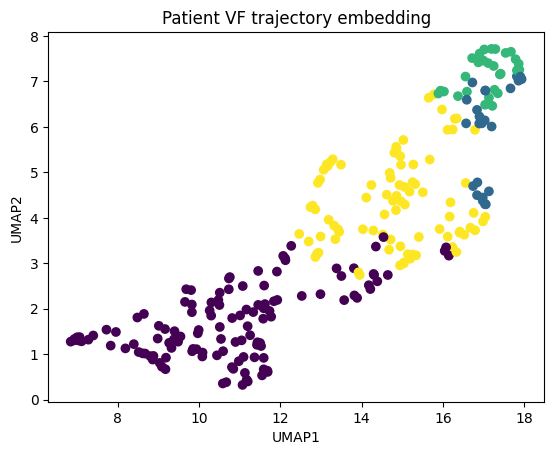

In [8]:
from sklearn.cluster import KMeans
from umap import UMAP
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=4)
labels = kmeans.fit_predict(patient_features)

umap = UMAP(n_neighbors=8, min_dist=0.1)
embedding_2d = umap.fit_transform(patient_features)



plt.scatter(embedding_2d[:,0], embedding_2d[:,1], c=labels)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("Patient VF trajectory embedding")
plt.show()


In [12]:
print(np.unique(labels, return_counts=True))

(array([0, 1, 2, 3], dtype=int32), array([125,  24,  28,  86]))


In [13]:
from sklearn.metrics import silhouette_score
score = silhouette_score(patient_features, labels)
print("Silhouette Score:", score)

Silhouette Score: 0.30055502179765065


In [14]:
from sklearn.metrics import calinski_harabasz_score
score = calinski_harabasz_score(patient_features, labels)
print("CH Index:", score)

CH Index: 149.0720783563535


n = 7 and 4 clusters. mean_embedding, mean_slope only. Silhouette Score: 0.3003501843879679 and CH Index: 146.31354664512173

In [15]:
clusters = {}
for c in np.unique(labels):
    clusters[c] = np.where(labels == c)[0]

In [16]:
for c, idx in clusters.items():
    print(c, len(idx))

0 125
1 24
2 28
3 86


In [21]:
baseline_means = {
    c: np.nanmean(patients[idx, 0, :], axis=0)
    for c, idx in clusters.items()
}

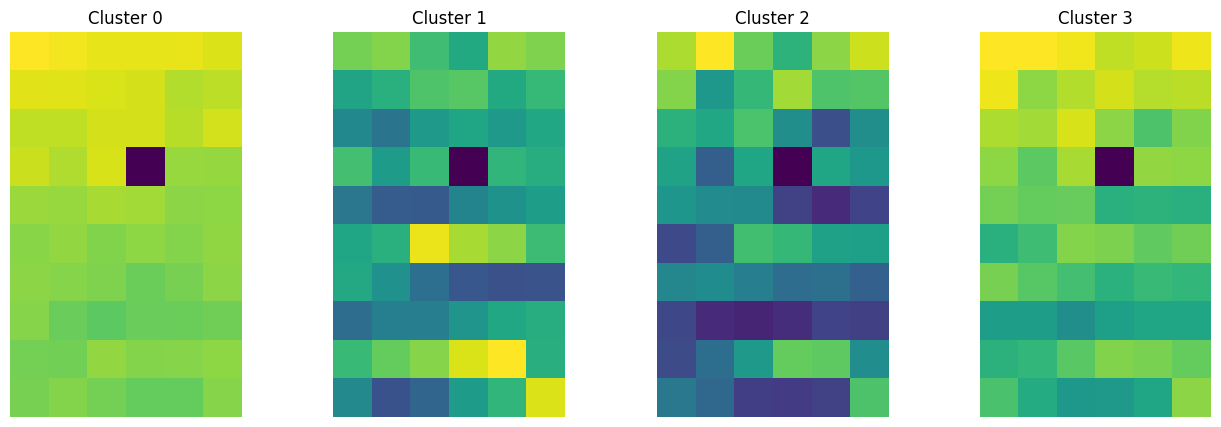

In [54]:
n_clusters = len(clusters)
fig, axes = plt.subplots(1, n_clusters, figsize=(4*n_clusters, 5))

for ax, c in zip(axes, clusters):
    m = baseline_means[c].reshape(10, 6)
    im = ax.imshow(m, cmap='viridis')
    ax.set_title(f"Cluster {c}")
    ax.axis('off') 

In [53]:
N, T, P = patients.shape
mean_slope_vf = np.zeros((N, P))

for i in range(N):
    valid_visits = patients[i][masks[i]==1]  # only real visits
    if len(valid_visits) > 1:
        diffs = np.diff(valid_visits, axis=0)  # difference between consecutive visits
        mean_slope_vf[i] = - np.mean(diffs, axis=0)  # average slope per VF location
    else:
        mean_slope_vf[i] = np.zeros(P)



cluster_slope_vf = {}
for c, idx in clusters.items():
    cluster_slope_vf[c] = np.mean(mean_slope_vf[idx], axis=0)


Text(0.5, 0.98, 'Mean Progression Slope per Cluster')

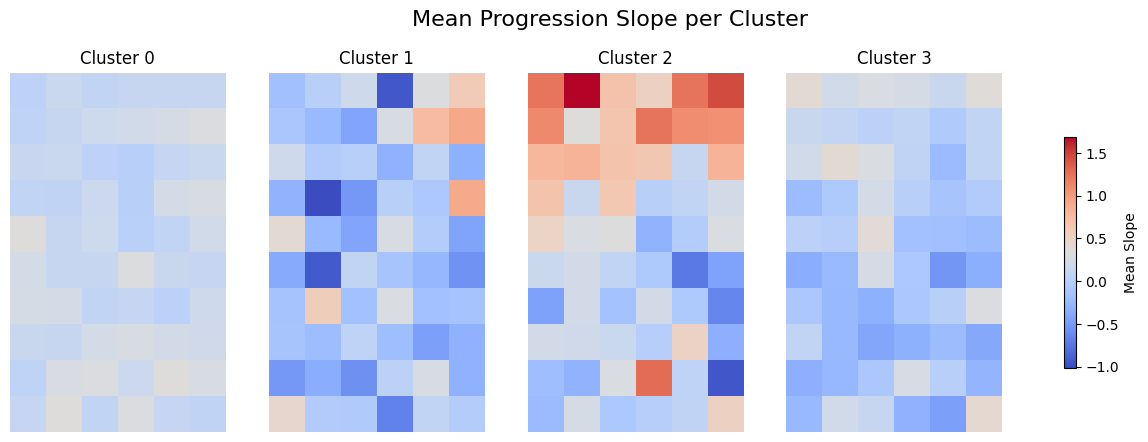

In [57]:
n_clusters = len(clusters)
fig, axes = plt.subplots(1, n_clusters, figsize=(4*n_clusters, 5))

vmin = min([cluster_slope_vf[c].min() for c in clusters])
vmax = max([cluster_slope_vf[c].max() for c in clusters])

for ax, c in zip(axes, clusters):
    s = cluster_slope_vf[c].reshape(10, 6)
    im = ax.imshow(s, cmap='coolwarm', vmin=vmin, vmax=vmax)
    ax.set_title(f"Cluster {c}")
    ax.axis('off')

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, label='Mean Slope')
plt.suptitle("Mean Progression Slope per Cluster", fontsize=16)


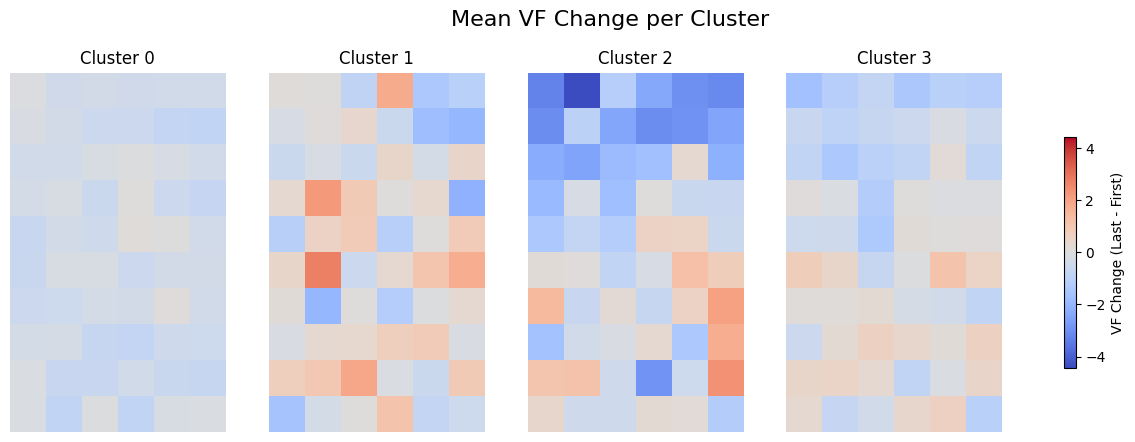

In [42]:
cluster_diff_vf = {}
for c, idx in clusters.items():
    diffs = []
    for i in idx:
        valid_visits = patients[i][masks[i]==1]  # only real visits
        if len(valid_visits) > 1:
            diff = valid_visits[-1] - valid_visits[0]  # last - first
            diffs.append(diff)
    cluster_diff_vf[c] = np.mean(diffs, axis=0)


rows, cols = 10, 6  # adjust to your VF layout
n_clusters = len(clusters)
fig, axes = plt.subplots(1, n_clusters, figsize=(4*n_clusters, 5))

vmin = min([cluster_diff_vf[c].min() for c in clusters])
vmax = max([cluster_diff_vf[c].max() for c in clusters])
vmax = max(abs(vmin), abs(vmax))  # symmetric color scale
vmin = -vmax

for ax, c in zip(axes, clusters):
    diff = cluster_diff_vf[c].reshape(rows, cols)
    im = ax.imshow(diff, cmap='coolwarm', vmin=vmin, vmax=vmax)
    ax.set_title(f"Cluster {c}")
    ax.axis('off')

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, label='VF Change (Last - First)')
plt.suptitle("Mean VF Change per Cluster", fontsize=16)
plt.show()